# Algoritmo 2 - Clustering

## Introdução
Exploramos atributos técnicos e físicos de jogadores/as do EA FC 24 para identificar padrões de semelhança com `KMeans`.
A análise foca em atletas de campo e procura responder: quantos segmentos coerentes existem, que características definem cada grupo e como género/posição se distribuem entre eles.

## Objetivo do notebook
Este caderno consolida o pipeline de clustering aplicado aos jogadores do FC 24.
Inclui preparação do ambiente, ingestão e limpeza dos dados, seleção de atributos, avaliação de `k` e análise qualitativa dos clusters com apoio de PCA, tabelas e visualizações.

### Preparação do ambiente
Instala as dependências necessárias diretamente no kernel para garantir versões alinhadas para `numpy`, `pandas`, `matplotlib` e `mlxtend`.

In [31]:
from sys import prefix

print("Hello World!")

%pip install --upgrade pip
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install mlxtend

Hello World!
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Carregamento e consolidação dos dados
Lemos os ficheiros femininos e masculinos do EA FC, adicionamos o campo `gender` e criamos um `DataFrame` único filtrado para a versão 24 do jogo.

In [32]:
import pandas as pd

# Carregar datasets e marcar genero
male_players = pd.read_csv("Data/EA_FC/male_players.csv",low_memory=False)
female_players = pd.read_csv("Data/EA_FC/female_players.csv")

male_players["gender"] = "M"
female_players["gender"] = "F"

players = pd.concat([male_players, female_players], ignore_index=True)

# Manter apenas registos do FC 24
players24 = players[players["fifa_version"] == 24].copy()


### Agrupamento de posições e filtro de jogadores
Convertimos `player_positions` em grupos agregados (GK/DEF/MID/ATT) e mantemos apenas defesas, médios e avançados para estudar perfis de atletas de campo.

In [33]:
# Agrupar pela primeira posicao listada
def map_position_group(positions_str: str) -> str:
    if pd.isna(positions_str):
        return "OTHER"
    main_pos = positions_str.split(",")[0].strip()
    # Grupos simplificados para reduzir dimensionalidade
    defenders = {"CB", "LB", "RB", "LWB", "RWB"}
    mids = {"CDM", "CM", "CAM", "LM", "RM"}
    attackers = {"ST", "CF", "LW", "RW"}

    if main_pos == "GK":
        return "GK"
    elif main_pos in defenders:
        return "DEF"
    elif main_pos in mids:
        return "MID"
    elif main_pos in attackers:
        return "ATT"
    else:
        return "OTHER"


def position_group_set(positions_str: str) -> set:
    if pd.isna(positions_str):
        return set()
    defenders = {"CB", "LB", "RB", "LWB", "RWB"}
    mids = {"CDM", "CM", "CAM", "LM", "RM"}
    attackers = {"ST", "CF", "LW", "RW"}

    groups = set()
    for pos in positions_str.split(","):
        p = pos.strip()
        if p == "GK":
            groups.add("GK")
        elif p in defenders:
            groups.add("DEF")
        elif p in mids:
            groups.add("MID")
        elif p in attackers:
            groups.add("ATT")
        else:
            groups.add("OTHER")
    return groups


players24["position_group"] = players24["player_positions"].apply(map_position_group)


# Isto remove jogadores que nao estejam no campo (tipo suplentes, ou guarda-redes)
Players24InField = players24[players24["position_group"].isin(["DEF", "MID", "ATT"])].copy()

# Filtrar jogadores com posicoes de um unico grupo (reduz ruido)
Players24InField["group_set"] = Players24InField["player_positions"].apply(position_group_set)
Players24InField["group_set_clean"] = Players24InField["group_set"].apply(
    lambda s: {g for g in s if g in {"DEF", "MID", "ATT"}}
)
Players24InField = Players24InField[
    Players24InField["group_set_clean"].apply(len) == 1
].copy()


### Selecao de atributos e normalizacao
Usamos apenas metricas detalhadas (attacking/skill/movement/power/mentality/defending) para alimentar o clustering. Mantemos apenas jogadores cujas posicoes listadas ficam no mesmo grupo (DEF/MID/ATT) para reduzir ruido, removemos linhas com `NaN` e aplicamos `StandardScaler` para colocar todas as escalas no mesmo patamar.


In [34]:
# Selecionar apenas atributos detalhados
detail_prefixes = (
    "attacking_",
    "skill_",
    "movement_",
    "power_",
    "mentality_",
    "defending_",
)
# Selecionar colunas por prefixo (ordem consistente)
feature_cols = sorted(
    [c for c in Players24InField.columns if c.startswith(detail_prefixes)]
)

# manter apenas linhas sem NaN nessas colunas
cluster = Players24InField.dropna(subset=feature_cols).copy()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Preparar matriz numerica para clustering
X = cluster[feature_cols].values

# Normalizar escala para KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Escolha de k e criacao dos clusters
Testamos valores de `k` entre 3 e 7 guardando inercia e *silhouette*. O `KMeans` final usa o `k` que maximiza a *silhouette* e avaliamos a precisao pelo mapeamento de maioria para `position_group`.


In [35]:
from IPython.display import display
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

# Avaliar k por silhouette e devolver labels
def evaluate_kmeans(X_scaled, k_values):
    inertias = []
    silhouettes = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_scaled, labels))

    best_k = k_values[silhouettes.index(max(silhouettes))]
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
    best_labels = kmeans.fit_predict(X_scaled)

    return best_k, inertias, silhouettes, best_labels


# Mapear cluster -> posicao dominante e calcular accuracy
def majority_map_accuracy(true_labels, cluster_labels):
    mapping = (
        pd.DataFrame({"cluster": cluster_labels, "position": true_labels})
        .groupby("cluster")["position"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    preds = pd.Series(cluster_labels, index=true_labels.index).map(mapping)
    acc = (preds == true_labels).mean()
    return acc, mapping, preds


# Intervalo de k a testar
k_values = list(range(3, 8))

best_k, inertias, silhouettes, labels = evaluate_kmeans(X_scaled, k_values)

true_labels = cluster["position_group"]

# Medidas de alinhamento com posicao real
ari = adjusted_rand_score(true_labels, labels)
nmi = normalized_mutual_info_score(true_labels, labels)
acc, mapping, preds = majority_map_accuracy(true_labels, labels)

print(f"Best k by silhouette: {best_k}")
print(f"Accuracy detailed (majority map): {acc:.2%}")
print(f"ARI: {ari:.4f} | NMI: {nmi:.4f}")

# Mapeamento cluster -> posicao dominante
display(mapping)

# Guardar labels e previsoes
cluster["cluster"] = labels
cluster["predicted_position"] = preds

# Matriz normalizada por posicao real
position_confusion = pd.crosstab(
    cluster["position_group"],
    cluster["predicted_position"],
    normalize="index",
).round(3)

display(position_confusion)

cluster_stats = cluster.groupby("cluster")[feature_cols].mean()

gender_counts = cluster.groupby(["cluster", "gender"]).size().unstack(fill_value=0)
gender_props = gender_counts.div(gender_counts.sum(axis=1), axis=0)


Best k by silhouette: 3
Accuracy detailed (majority map): 68.86%
ARI: 0.3200 | NMI: 0.3360


cluster
0    MID
1    DEF
2    ATT
Name: position, dtype: object

predicted_position,ATT,DEF,MID
position_group,,,
ATT,0.798,0.002,0.200
DEF,0.012,0.741,0.247
MID,0.276,0.145,0.579


### Projeção em 2D com PCA
Aplicamos PCA para reduzir as componentes e visualizar a separação dos clusters em duas dimensões, facilitando interpretação visual da segmentação.

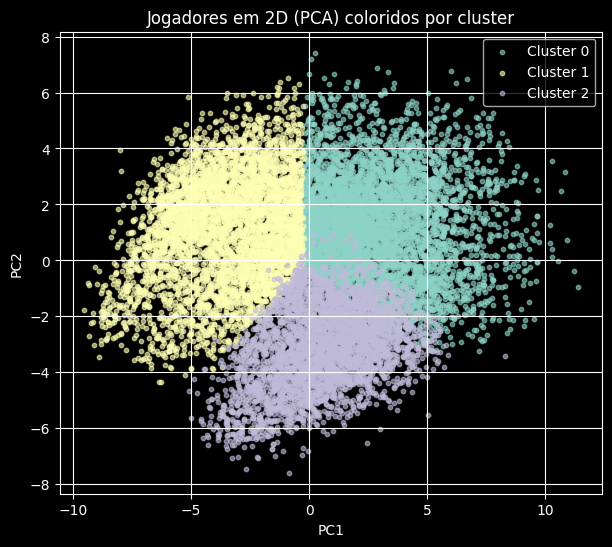

In [36]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# Projetar em 2D para visualizacao
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(X_scaled)

cluster["pc1"] = coords_2d[:, 0]
cluster["pc2"] = coords_2d[:, 1]

# Dispersao por cluster no PCA
plt.figure(figsize=(7,6))
for c in sorted(cluster["cluster"].unique()):
    subset = cluster[cluster["cluster"] == c]
    plt.scatter(subset["pc1"], subset["pc2"], label=f"Cluster {c}", alpha=0.6, s=10)





plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Jogadores em 2D (PCA) coloridos por cluster")
plt.legend()
plt.grid(True)
plt.show()


### Estatísticas médias por cluster
Geramos uma tabela com a média de cada atributo nas diferentes etiquetas para interpretar as características dominantes de cada segmento.

In [37]:
# Medias por cluster para interpretar perfis
cluster_means = cluster.groupby("cluster")[feature_cols].mean().round(1)
cluster_means


,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,defending_marking_awareness,defending_sliding_tackle,defending_standing_tackle,mentality_aggression,mentality_composure,...,power_long_shots,power_shot_power,power_stamina,power_strength,skill_ball_control,skill_curve,skill_dribbling,skill_fk_accuracy,skill_long_passing,skill_moves
cluster,,,,,,,,,,,,,,,,,,,,,
0,63.2,58.5,59.1,71.7,53.6,60.4,59.3,63.0,66.6,68.4,...,62.0,67.2,74.1,67.2,71.5,62.7,69.3,56.9,67.3,2.8
1,44.4,32.8,59.7,58.5,31.8,61.8,62.1,64.2,63.7,55.0,...,34.3,46.7,64.8,70.1,56.0,39.1,49.8,34.3,52.7,2.0
2,49.4,60.7,53.7,59.2,52.8,30.1,29.2,31.3,48.5,57.7,...,56.0,62.1,60.4,61.0,63.4,51.6,63.2,46.5,49.7,2.7


### Distribuição de posições dentro de cada cluster
Calculamos contagens e proporções por `position_group` para verificar se há clusters dominados por defesas, médios ou avançados.

In [38]:
# Proporcoes por posicao dentro de cada cluster
pos_counts = cluster.groupby(["cluster", "position_group"]).size().unstack(fill_value=0)
pos_props = pos_counts.div(pos_counts.sum(axis=1), axis=0)
pos_props


position_group,ATT,DEF,MID
cluster,,,
0,0.109505,0.271881,0.618614
1,0.001222,0.838867,0.159910
2,0.586564,0.017791,0.395645


### Análise de género por cluster
Usamos `crosstab` para obter contagens e proporções de homens e mulheres em cada cluster, avaliando possíveis enviesamentos de género.

In [39]:
# Distribuicao de genero por cluster
# tabela cluster x género
ct = pd.crosstab(cluster["cluster"], cluster["gender"])
print(ct)

# proporções dentro de cada cluster
props = ct.div(ct.sum(axis=1), axis=0)
print(props)


gender     F     M
cluster           
0        825  4225
1        286  4623
2        199  3567
gender          F         M
cluster                    
0        0.163366  0.836634
1        0.058260  0.941740
2        0.052841  0.947159


### Visualizações PCA segmentadas por cluster e género
As figuras seguintes reforçam a leitura dos clusters no espaço 2D, primeiro distinguindo rótulos e géneros simultaneamente e depois apenas por género para identificar sobreposições.

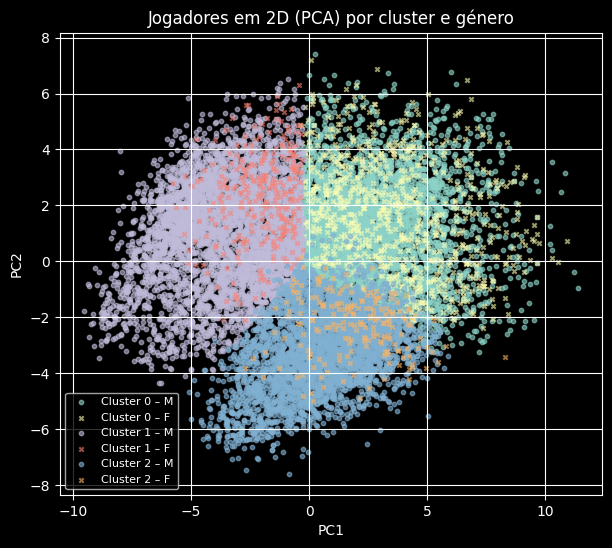

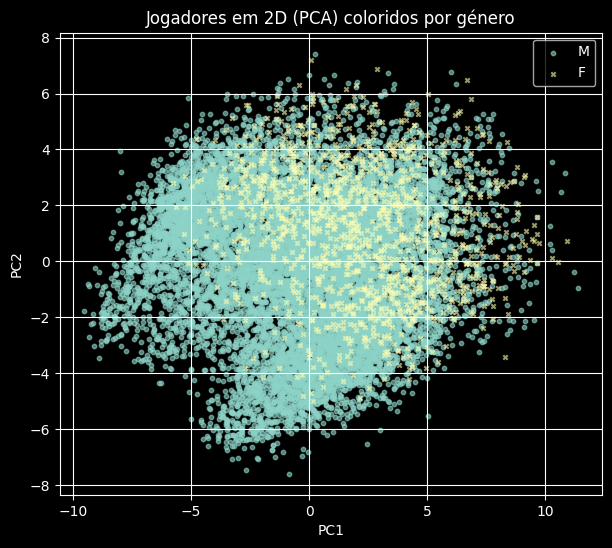

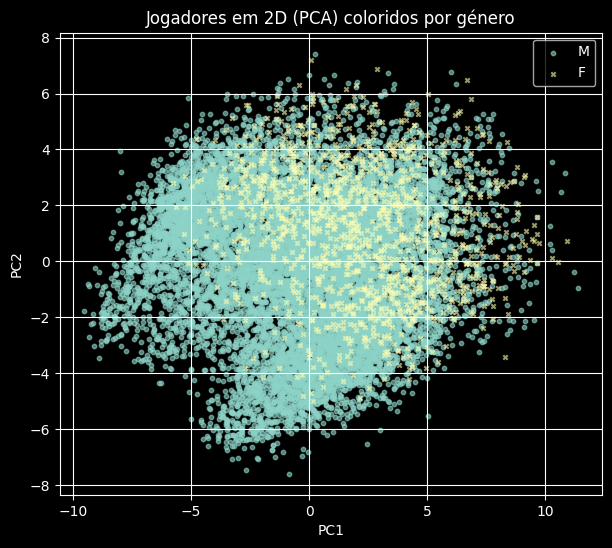

In [40]:
import matplotlib.pyplot as plt

# Visualizacao PCA por cluster e genero
markers = {"M": "o", "F": "x"}  # círculo para M, X para F

plt.figure(figsize=(7, 6))

for c in sorted(cluster["cluster"].unique()):
    for g in ["M", "F"]:
        subset = cluster[(cluster["cluster"] == c) & (cluster["gender"] == g)]
        if subset.empty:
            continue

        plt.scatter(
            subset["pc1"],
            subset["pc2"],
            marker=markers[g],
            alpha=0.6,
            s=10,
            label=f"Cluster {c} – {g}"
        )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Jogadores em 2D (PCA) por cluster e género")
plt.legend(loc="best", fontsize=8)
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 6))

markers = {"M": "o", "F": "x"}

for g in ["M", "F"]:
    subset = cluster[cluster["gender"] == g]
    plt.scatter(
        subset["pc1"],
        subset["pc2"],
        marker=markers[g],
        alpha=0.6,
        s=10,
        label=g
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Jogadores em 2D (PCA) coloridos por género")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 6))

markers = {"M": "o", "F": "x"}

for g in ["M", "F"]:
    subset = cluster[cluster["gender"] == g]
    plt.scatter(
        subset["pc1"],
        subset["pc2"],
        marker=markers[g],
        alpha=0.6,
        s=10,
        label=g
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Jogadores em 2D (PCA) coloridos por género")
plt.legend()
plt.grid(True)
plt.show()


## Conclusão
Os clusters revelam perfis distintos combinando velocidade, técnica e força, permitindo descrever arquétipos de jogadores/as em campo.
As tabelas de género e posição confirmam que os segmentos não são monopolizados por um único grupo, embora alguns apresentem maior concentração de médios ou avançados.
As projeções PCA ajudam a validar a separação entre clusters e evidenciam ligeiras diferenças entre masculino e feminino.
Próximos passos possíveis incluem testar outros algoritmos (e.g., GMM), ajustar `k` com métricas adicionais e gerar relatórios automatizados por equipa ou liga.